# assigns conserved cell type names to processed datasets and adds imputations

In [1]:
## conda activate r4
## packages for data table processing

#IRkernel::installspec()

## main Seurat package snRNA-seq packages
library(Seurat)
library(SeuratDisk)
library(SeuratWrappers)
library(future)

library(here)
library(tidyverse)

library(dplyr)

library(caret)
library(cluster)

#install.packages('hash')
library(hash)
library(viridis)

library(ggpubr)
library(ggplot2)
options(repr.plot.width=30, repr.plot.height=10)

ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F)
options(repr.plot.width=11, repr.plot.height=8.5)

#######################################################
# 0) Seurat uses the future package for parallelization
## set to be parallel over 28 cores
plan("multicore", workers = 28)
options(future.globals.maxSize = 100 * 1024^3)
options(future.rng.onMisuse = 'ignore')

Warning message:
“package ‘Seurat’ was built under R version 4.1.3”
Attaching SeuratObject

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Warning message:
“package ‘future’ was built under R version 4.1.3”
Warning message:
“package ‘here’ was built under R version 4.1.3”
here() starts at /projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”
Warning message:
“package ‘tibble’ was built under R version 4.1.3”
Warning message:
“package ‘dplyr’ was built under R version 4.1.3”
── Conflicts ─────────────────────────────────────────────

In [2]:
# load human and macaque rna dataset
macaque_rna = LoadH5Seurat("/projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq/data/tidy_data/rdas/macaque_integrated_neuronsv3.h5seurat",assay = "RNA")
macaque_rna$nCount_RNA = macaque_rna$nUMI # equivalent data
macaque_rna$nFeature_RNA = macaque_rna$nGene # equivalent data

human_rna = readRDS('/projects/pfenninggroup/singleCell/HumanMacaqueMouse_DorsalHorn_snRNA-Seq/data/tidy_data/Levine_Human_dorsal_horn_celltypes/rdas/human_neurons.rds')

mouse_rna = LoadH5Seurat('/home/bnphan/projects/2022_DH_Russ_cell_types/data/tidy_data/rdas/Russ_et_al_dorsal_horn_neurons.h5seurat')
mouse_rna = mouse_rna[, mouse_rna$dataset == 'Sathyamurthy']
Idents(object = mouse_rna) <- "final_cluster_assignment"
#DefaultAssay(mouse_rna) = 'RNA'

## human and macaque subset to dorsal horn
human_cell_types = unique(human_rna$final_ann)
human_dh_types = human_cell_types[grep('Dorsal', human_cell_types)]

macaque_cell_types = unique(macaque_rna$cluster_type)
GLUTs = macaque_cell_types[grep('GLUT', macaque_cell_types)]
GABAs = macaque_cell_types[grep('GABA', macaque_cell_types)]
macaque_dh_types = c(GLUTs, GABAs)

Idents(object = human_rna) <- "final_ann"
human_rna_dh = subset(x = human_rna, idents = human_dh_types)
rm(human_rna)

Idents(object = macaque_rna) <- "cluster_type"
macaque_rna_dh = subset(x = macaque_rna, idents = macaque_dh_types)
rm(macaque_rna)

macaque_rna_dh$macaque = macaque_rna_dh$cluster_type


### mouse genes to human genes
convertHumanGeneList <- function(x){
  file = '/home/bnphan/resources/genomes/GRCh38.p13/ENSEMBL_GRCh38.p13_genes_to_Orthologous_mouse_genes.tsv'
  orthologs = read_tsv(file, show_col_types = FALSE) %>% 
    rename_with(make.names) %>% 
    dplyr::filter(Mouse.homology.type== 'ortholog_one2one') %>% 
    dplyr::filter(Mouse.gene.name %in% x) %>% 
    dplyr::select(Mouse.gene.name, Gene.name)
  
  # Print the first 6 genes found to the screen
  print(head(orthologs))
  return(orthologs)
}
# RenameGenesSeurat from https://github.com/satijalab/seurat/issues/1049
RenameGenesSeurat <- function(obj, newnames) {
  # Replace gene names in different slots of a Seurat object. Run this before integration.
  # It only changes obj@assays$RNA@counts, @data and @scale.data.
  print("Run this before integration. It only changes obj@assays$RNA@counts, @data and @scale.data.")
  RNA <- obj@assays$RNA

  if (nrow(RNA) == length(newnames)) {
    if (length(RNA@counts)) RNA@counts@Dimnames[[1]]            <- newnames
    if (length(RNA@data)) RNA@data@Dimnames[[1]]                <- newnames
    if (length(RNA@scale.data)) RNA@scale.data@Dimnames[[1]]    <- newnames
  } else {"Unequal gene sets: nrow(RNA) != nrow(newnames)"}
  obj@assays$RNA <- RNA
  return(obj)
}

## switch out human gene names w/ orthologous mouse gene names, based on ENSEMBL
MmtoHg = convertHumanGeneList(rownames(mouse_rna)) %>% deframe()
HgtoMm = setNames(names(MmtoHg), MmtoHg)
# mouse_rna = mouse_rna[names(MmtoHg[!is.na(MmtoHg)]), ]
# mouse_rna = RenameGenesSeurat(mouse_rna, newnames = MmtoHg[rownames(mouse_rna)])
# mouse_rna = mouse_rna[!is.na(rownames(mouse_rna)), ]
# head(rownames(mouse_rna))

# firstup <- function(x) {
#   substr(x, 1, 1) <- toupper(substr(x, 1, 1))
#   x
# }

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding feature-level metadata for RNA

Adding reduction pca

Adding cell embeddings for pca

Adding miscellaneous information for pca

Adding reduction scanorama

Adding cell embeddings for scanorama

Adding miscellaneous information for scanorama

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding command information

Adding cell-level metadata

Validating h5Seurat file

Initializing MAGIC_RNA with data

Adding miscellaneous information for MAGIC_RNA

Initializing MAGIC_SCT with data

Adding miscellaneous information for MAGIC_SCT

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding variable feature information for SCT

Adding miscellaneous information for SCT

Initializing alra with data

Adding miscellaneous information for alra


# A tibble: 6 × 2
  Mouse.gene.name Gene.name
  <chr>           <chr>    
1 Usp9y           USP9Y    
2 Kdm5d           KDM5D    
3 Sry             SRY      
4 Zfx             ZFY      
5 Ddx3y           DDX3Y    
6 Uty             UTY      


In [ ]:
human_to_macaque_predictions = readRDS(file = here("data/tidy_data/rdas/macaque_labels_for_human2023-08-16.rds"))
mouse_to_macaque_predictions = readRDS(file = here("data/tidy_data/rdas/macaque_labels_for_mouse2023-08-16.rds"))

mouse_rna <- AddMetaData(object = mouse_rna, metadata = mouse_to_macaque_predictions)
human_rna_dh <- AddMetaData(object = human_rna_dh, metadata = human_to_macaque_predictions)
Idents(human_rna_dh) <- 'predicted.id'
Idents(mouse_rna) <- 'predicted.id'

######## order of cell types to appear in figures
mouse_levels <- c('GLUT1','GLUT2','GLUT3','GLUT4','GLUT5','GLUT6','GLUT7','GLUT8','GLUT9','GLUT10','GLUT11',
                  'GABA1','GABA2_1','GABA2_2','GABA3','GABA4_1','GABA4_2','GABA5')
human_levels <- c('GLUT1','GLUT2','GLUT3','GLUT4','GLUT5','GLUT6','GLUT7','GLUT8','GLUT9','GLUT10','GLUT11',
                  'GABA1','GABA2_1','GABA2_2','GABA3','GABA4_1','GABA4_2','GABA5')

# Relevel object@ident
Idents(mouse_rna) <- factor(Idents(mouse_rna), levels= mouse_levels)
Idents(human_rna_dh) <- factor(Idents(human_rna_dh), levels= human_levels)

In [4]:
# add ALRA imputation to macaque and human. already there in mouse
# ALRA imputation. Based on:
#https://github.com/satijalab/seurat-wrappers/blob/master/docs/alra.md
macaque_rna_dh <- SCTransform(macaque_rna_dh) %>% RunPCA() %>% RunUMAP(dims = 1:30)
macaque_rna_dh <- RunALRA(macaque_rna_dh)
human_rna_dh <- SCTransform(human_rna_dh) %>% RunPCA() %>% RunUMAP(dims = 1:30)
human_rna_dh <- RunALRA(human_rna_dh)

# set default assays as ALRA
DefaultAssay(mouse_rna) = 'alra'
DefaultAssay(macaque_rna_dh) = 'alra'
DefaultAssay(human_rna_dh) = 'alra'


Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 23924 by 1954

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1954 cells



  |======================================================================| 100%


Found 109 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 23924 genes



  |======================================================================| 100%


Computing corrected count matrix for 23924 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.009977 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

PC_ 1 
Positive:  DSCAML1, GRIK1, NXPH1, LHX1-DT, CHRM3, CADPS2, GRIK3, PENK, CLSTN2, MET 
	   RORB, FAM163A, AC024230.1, ABTB2, AC011246.1, TCF7L1, GCGR, PDYN, GIPR, PTPRT 
	   INHBA, SKOR1, ADGRG4, VWA5B1, LHX5, ASAP3, BOC, CYP1B1-AS1, IGFBP4, AC020911.2 
Negative:  EBF2, CASZ1, ADAMTS9-AS2, SYT10, SHISA6, GFRA1, PREX2, ZNF536, ERBB4, BNC2 
	   GALNTL6, FSTL4, NMUR2, MEGF6, AC007368.1, CRHR2, AC021594.2, AL133304.3, WLS, ADAMTS9 
	   NTNG1, TRH, GPR179, TMEM114, COL13A1, HMGA2, COL2A1, PLCH2, RASD2, AC018953.2 
PC_ 2 
Positive:  PREX2, ZNF536, SYT10, GALNTL6, NMUR2, MEGF6, GFRA1, CNGB1, AC024230.1, C1QTNF7 
	   NFIX, BNC2, HMGA2, CRHR2, SFRP1, CCDC102B, GRIK3, LLGL2, COL13A1, CUX2 
	   AEBP1, DRAXIN, PTPRT, FAM163A, AC109466.1, COL9A2, TCF7L1, GPR179, ANO1, PDYN 
Negative:  FSTL4, N

  |======================================================================| 100%


Found 66 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 17201 genes



  |======================================================================| 100%


Computing corrected count matrix for 17201 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 39.58134 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

PC_ 1 
Positive:  NRXN3, NRG1, NXPH1, DSCAML1, PLCB1, CACNA2D3, FSTL5, GRIK2, GAD1, GPC6 
	   GPC5, CHRM3, NPPC, HDAC9, ZNF385D, HS6ST3, CDH18, PAX2, ROBO1, MPPED2 
	   GRIK1, CACHD1, PLCH1, LRRTM4, ADCY8, DMD, GULP1, CLSTN2, ZMAT4, GAD2 
Negative:  CACNA2D1, MAML3, EBF2, DSCAM, BCL2, CPNE8, SEMA3C, EBF1, CPNE4, ERBB4 
	   DOCK8, MAML2, SOX5, PTPRD, ROBO2, NPY1R, SYT10, GRID1, SST, GALNTL6 
	   LDB2, LHFPL3, KLHL1, MAPK4, GREB1L, PREX2, RELN, SPOCK1, LMX1B, KCNIP4 
PC_ 2 
Positive:  GRIN2A, EPHA6, SYNPR, EBF2, KIRREL3, DCC, KCNH7, CDH13, TSHZ2, LINC01798 
	   LRRC4C, KCNH8, GALNT18, ARPP21, NTM, COBL, CASZ1, GLRA3, SEZ6L, NTNG1 
	   LDB2, DACH1, ADARB2, CA10, TRPM3, MEIS1, SNTG1, BRINP2, PLCB4, SNTB1 
Negative:  DPP10, PCDH15, KLHL1, CAMK1D, STK32A, TAC1, SEMA5A, RELN, PLD5, PTPRR 
	 

In [5]:
## scale data for heatmaps: https://satijalab.org/seurat/reference/scaledata
human_rna_dh <- ScaleData(human_rna_dh)
mouse_rna <- ScaleData(mouse_rna)
macaque_rna_dh <- ScaleData(macaque_rna_dh)## scale data for heatmaps: https://satijalab.org/seurat/reference/scaledata

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix



In [6]:
#Final set of features
features = c('BNC2','HMGA2','NMUR2','PREX2','NMU','TAC3',' COL5A2', 'PLCH1','LMO3', 'TRPC3','SKOR2', 'NELL2','MAF','ADARB2', 'MAFA', 'NTS','TSHZ2', 'SNTB1', 'TRH','DACH1','PBX3','SLIT2',
            'CACNA2D3','TCF4', 'SORCS1','SDK1', 'PDZD2','SGCD', 'NPY','ZIC1', 'MEF2C','RORB','NXPH1', 'SDK2','PDYN','PTPRK')
mouse_features = as.character(HgtoMm[features])

macaque_ordered_types = c('GLUT1','GLUT2','GLUT3','GLUT4','GLUT5','GLUT6','GLUT7','GLUT8','GLUT9','GLUT10','GLUT11',
                          'GABA1','GABA2_1','GABA2_2','GABA3','GABA4_2','GABA4_1','GABA5')
new_cell_names = c('Exc-BNC2/HMGA2','Exc-NMUR2/PREX2', 'Exc-NMU/TAC3', 'Exc-TAC3/COL5A2/PLCH1','Exc-LMO3/TRPC3', 'Exc-SKOR2/NELL2', 'Exc-MAF/ADARB2', 'Exc-MAFA/BNC2', 
                  'Exc-NTS/TSHZ2', 'Exc-SNTB1/TRH/DACH1', 'Exc-PBX3/SLIT2', 
                  'Inh-CACNA2D3/TCF4', 'Inh-SORCS1/SDK1', 'Inh-PDZD2/SGCD', 'Inh-NPY/ZIC1', 'Inh-MEF2C/RORB','Inh-NXPH1/SDK2','Inh-PDYN/PTPRK')

names(new_cell_names) = macaque_ordered_types
new_cell_nicknames = c('Exc-BNC2','Exc-NMUR2', 'Exc-NMU', 'Exc-TAC3','Exc-LMO3', 'Exc-SKOR2', 'Exc-MAF', 'Exc-MAFA', 
                  'Exc-NTS', 'Exc-SNTB1', 'Exc-PBX3', 'Inh-CACNA2D3', 'Inh-SORCS1', 'Inh-PDZD2', 'Inh-NPY', 'Inh-MEF2C','Inh-NXPH1','Inh-PDYN')
names(new_cell_nicknames) = macaque_ordered_types

In [7]:
# new names
macaque_rna_dh$conserved_marker_names = new_cell_names[macaque_rna_dh$cluster_type]
human_rna_dh$conserved_marker_names = new_cell_names[human_rna_dh$predicted.id]
mouse_rna$conserved_marker_names = new_cell_names[mouse_rna$predicted.id]

# new nicknames
macaque_rna_dh$conserved_marker_nicknames = new_cell_nicknames[macaque_rna_dh$cluster_type]
human_rna_dh$conserved_marker_nicknames = new_cell_nicknames[human_rna_dh$predicted.id]
mouse_rna$conserved_marker_nicknames = new_cell_nicknames[mouse_rna$predicted.id]

In [11]:
table(mouse_rna$conserved_marker_nicknames)


    Exc-BNC2     Exc-LMO3      Exc-MAF     Exc-MAFA      Exc-NMU    Exc-NMUR2 
         176          291          447          126          278          285 
     Exc-NTS     Exc-PBX3    Exc-SKOR2    Exc-SNTB1     Exc-TAC3 Inh-CACNA2D3 
         154          184          219           95            1          267 
   Inh-MEF2C      Inh-NPY    Inh-NXPH1     Inh-PDYN    Inh-PDZD2   Inh-SORCS1 
         188          205          169          340          175          268 

In [12]:
# save datasets
filename = "/projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq/data/tidy_data/rdas/mouse_rna_dh_conserved_names.h5seurat"
SaveH5Seurat(mouse_rna, filename)

filename = "/projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq/data/tidy_data/rdas/human_rna_dh_conserved_names.h5seurat"
SaveH5Seurat(human_rna_dh, filename)

filename = "/projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq/data/tidy_data/rdas/macaque_rna_dh_conserved_names.h5seurat"
SaveH5Seurat(macaque_rna_dh, filename)

Creating h5Seurat file for version 3.1.5.9900

Adding data for alra

Adding scale.data for alra

No variable features found for alra

No feature-level metadata found for alra

Adding data for MAGIC_RNA

No variable features found for MAGIC_RNA

No feature-level metadata found for MAGIC_RNA

Adding data for MAGIC_SCT

No variable features found for MAGIC_SCT

No feature-level metadata found for MAGIC_SCT

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding counts for SCT

Adding data for SCT

Adding scale.data for SCT

Adding variable features for SCT

No feature-level metadata found for SCT

Writing out SCTModel.list for SCT

Adding data for integrated

Adding scale.data for integrated

Adding variable features for integrated

No feature-level metadata found for integrated

Adding cell embeddings for pca

Adding loadings for pca

No projected loadings for pca

Adding standard deviations for pca

No JackStraw da

In [92]:
Idents(object = mouse_rna) <- factor(x = mouse_rna$conserved_marker_nicknames, levels = new_cell_nicknames)
Idents(object = macaque_rna_dh) <- factor(x = macaque_rna_dh$conserved_marker_nicknames, levels = new_cell_nicknames)
Idents(object = human_rna_dh) <- factor(x = human_rna_dh$conserved_marker_nicknames, levels = new_cell_nicknames)

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



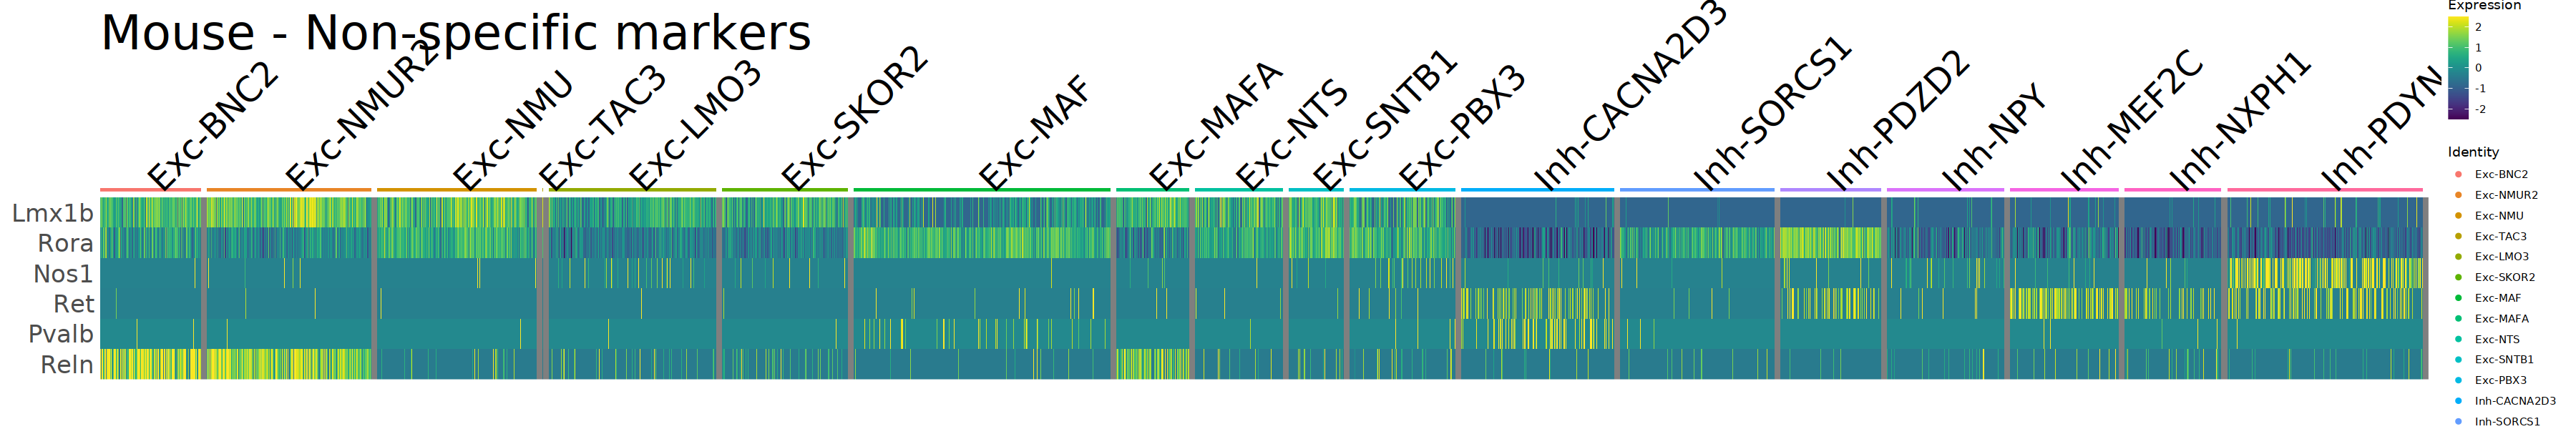

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



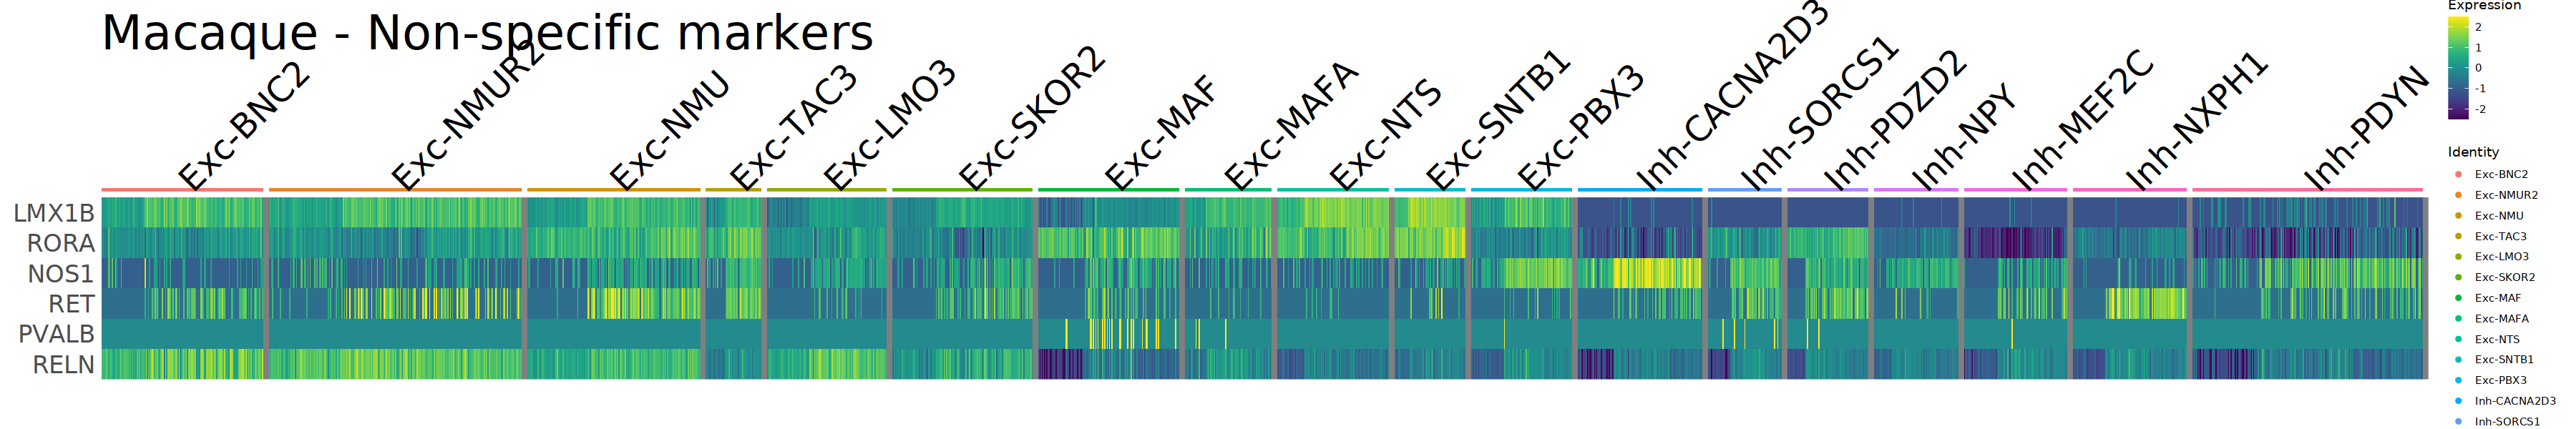

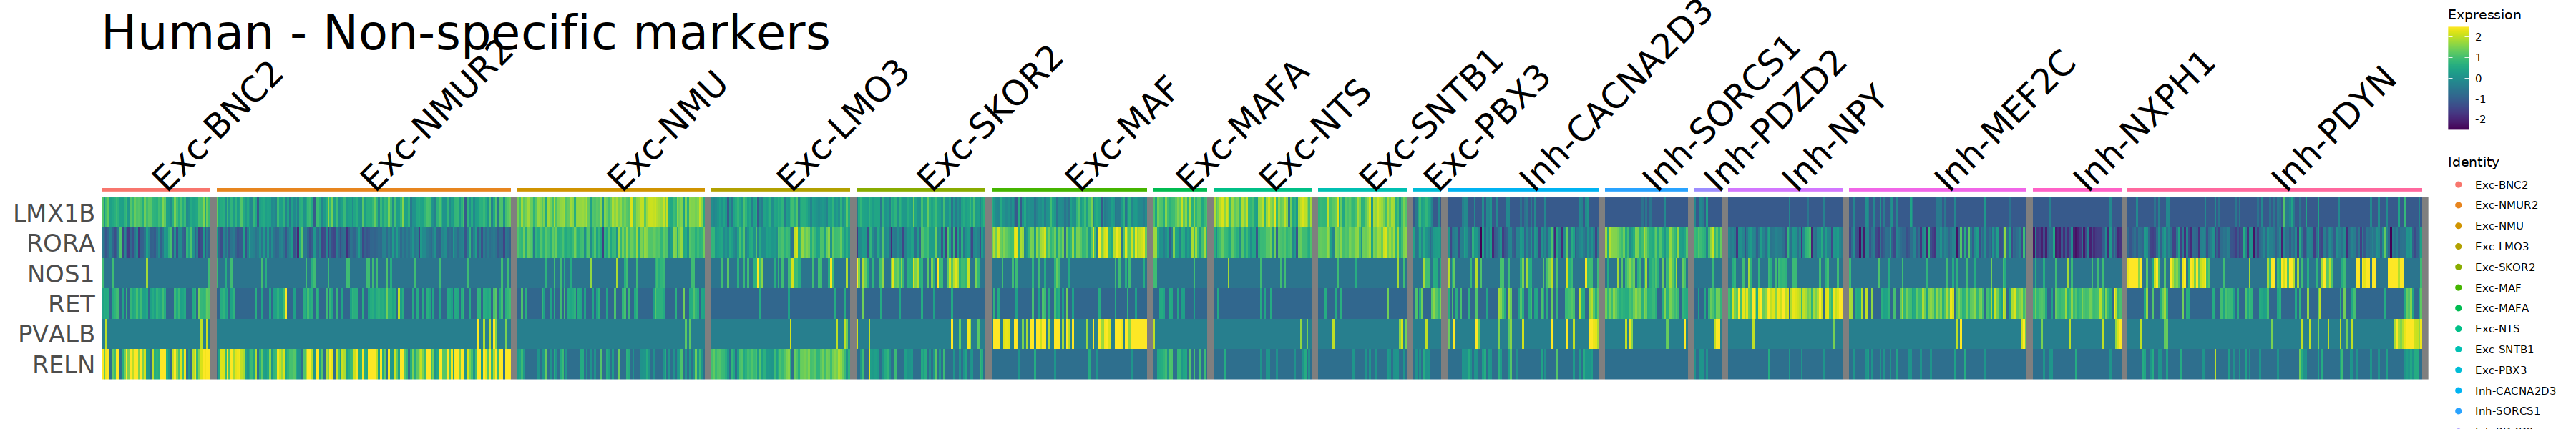

In [95]:
options(repr.plot.width=30, repr.plot.height=5)
DoHeatmap(object = mouse_rna, features = mouse_historical_markers0,slot = 'scale.data', size = 10) + scale_fill_viridis() + ggtitle('Mouse - Non-specific markers \n') +
theme(plot.title=element_text(family='', face='bold', colour='black', size=40), axis.text=element_text(size=20))

options(repr.plot.width=30, repr.plot.height=5)
DoHeatmap(object = macaque_rna_dh, features = historical_markers0,slot = 'scale.data', size = 10) + scale_fill_viridis() + ggtitle('Macaque - Non-specific markers \n') +
theme(plot.title=element_text(family='', face='bold', colour='black', size=40), axis.text=element_text(size=20))

options(repr.plot.width=30, repr.plot.height=5)
DoHeatmap(object = human_rna_dh, features = historical_markers0,slot = 'scale.data', size = 10) + scale_fill_viridis() + ggtitle('Human - Non-specific markers \n') +
theme(plot.title=element_text(family='', face='bold', colour='black', size=40), axis.text=element_text(size=20))